In [6]:
# load dataset
from sklearn.datasets import load_iris

dataset = load_iris()

X,y = dataset.data, dataset.target

In [7]:
# split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# scaling 
from sklearn.preprocessing import MinMaxScaler

scaled = MinMaxScaler()
X_train = scaled.fit_transform(X_train)
X_test = scaled.transform(X_test)

In [8]:
# fungsi objective
from sklearn.ensemble import RandomForestClassifier
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 15)

    # buat model dengan hyperparameter yang di uji
    model = RandomForestClassifier(
        random_state=42,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )

    # evaluasi model dengan cross validation score
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()

    return score

In [9]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Lihat hasil tuning
print('\nbest Hyperparameters : ', study.best_trial.params)
print('best accuracy :', study.best_trial.value)

[I 2025-03-23 12:00:04,149] A new study created in memory with name: no-name-2c86f1b4-e969-4ebf-9b20-2f88fc7374a5
[I 2025-03-23 12:00:04,918] Trial 0 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 130, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9333333333333333.
[I 2025-03-23 12:00:06,212] Trial 1 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 225, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.9333333333333333.
[I 2025-03-23 12:00:07,574] Trial 2 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 239, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.9333333333333333.
[I 2025-03-23 12:00:09,082] Trial 3 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 260, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 0 with val


best Hyperparameters :  {'n_estimators': 149, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 12}
best accuracy : 0.9523809523809523


In [11]:
# Coba evaluasi model dengan hyperparameter terbaik
from sklearn.metrics import accuracy_score

# Ambil hyperparameter terbaik dari hasil tuning Optuna
best_rf = study.best_trial.params

# Ambil parameter dari dictionary best_rf
n_estimators = best_rf["n_estimators"]
max_depth = best_rf["max_depth"]
min_samples_split = best_rf["min_samples_split"]
min_samples_leaf = best_rf['min_samples_leaf']

# Buat model dengan hyperparameter terbaik
best_model = RandomForestClassifier(
    random_state=42,
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf
)

# Train ulang model dengan data training
best_model.fit(X_train, y_train)

# Evaluasi model
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Best Hyperparameters: {best_rf}')
print(f'Accuracy: {accuracy:.4f}')


Best Hyperparameters: {'n_estimators': 149, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 12}
Accuracy: 1.0000


## 1️⃣ Cek Overfitting atau Tidak

In [12]:
# cross validation score
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# confusion matrix & classification report 
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Cross-Validation Accuracy: 0.9524 ± 0.0426
Confusion Matrix:
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



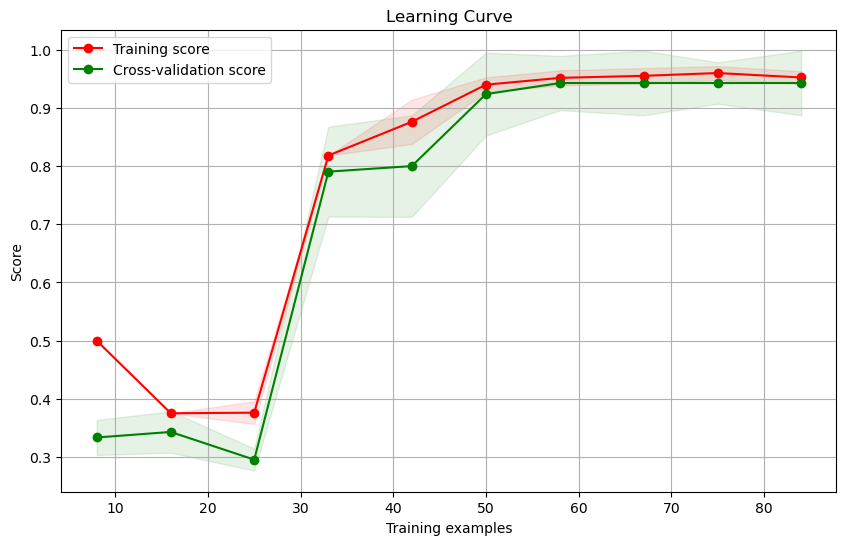

In [13]:
# learning curve berdasarkan training model

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid()
plt.show()